# ML1 Final Project: F1 Race Finish Prediction
**Work by LT 2**

---

In [111]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import ceil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import KFold
import seaborn as sns
# from sklearn.model_selection import train_test_split

In [112]:

# # !pip install pandas numpy matplotlib plotly scikit-learn seaborn
# !pip install mord 
# !pip uninstall jupyter jupyterlab -y
# !pip uninstall ipykernel -y
# !pip install ipykernel
# !python -m ipykernel install --user --name .F1_venv --display-name "F1_venv"
# !pip install numpy pandas matplotlib seaborn plotly scikit-learn scipy xgboost lightgbm pyswarms scikit-optimize mord


# LOAD AND PREPARE DATA

Test Dataset 1

In [113]:
# # Load and clean data
# data = pd.read_csv("traffic_crashes_people.csv")
# data = data.drop(['physical_condition', 'airbag_deployed', 'ejection'], axis=1)
# # Random sample 8,000 rows using seed 1337
# data = data.dropna().reset_index(drop=True)
# data = data.sample(n=25000, random_state=1337)
# target = 'injury_classification'
# data.head()

Test Dataset 2

In [114]:
# # Cleanning Method 2 ================================
# data = pd.read_table('fruit_data_with_colors.txt')
# data = data.dropna().drop(columns=['fruit_subtype', 'fruit_label'])
# target = "fruit_name"
# data.head()


Test Dataset 3

In [115]:
# Load and clean data
data_raw = pd.read_csv("F1_main_data_v9.csv")
data = data_raw.copy()
# data = data.drop(['physical_condition', 'airbag_deployed', 'ejection'], axis=1)
# Random sample 8,000 rows using seed 1337
# data = data.dropna().reset_index(drop=True)
# data = data.sample(n=25000, random_state=1337)
# data=data.drop(columns=["Timestamp","driver_code","GrandPrix","team","Consistency_Race", "Style_Race",
#                         "Technical_Race","Pace_Race","PerformanceIndex_Race"])
data=data.drop(columns=["Timestamp","driver_code","GrandPrix","Consistency_Race", "Style_Race",
                        "Technical_Race","Pace_Race","PerformanceIndex_Race","driver_points","team_points"])
target = 'RaceFinishPosition'
# print(data.head())
print(data.head())

   Consistency_Qual  Style_Qual  Technical_Qual  Pace_Qual  \
0             0.254       0.203           0.403      0.800   
1             0.000       0.200           0.305      0.750   
2             0.169       0.500           0.417      0.900   
3             0.341       0.203           0.190      0.950   
4             0.464       0.792           0.232      0.850   

   PerformanceIndex_Qual  Round  year  QualifyingPosition  RaceFinishPosition  \
0                  0.415     12  2025                   5               4.000   
1                  0.314     12  2025                   6              14.000   
2                  0.497     12  2025                   3               1.000   
3                  0.421     12  2025                   2               2.000   
4                  0.584     12  2025                   4              10.000   

       team  ...  Finish_pct  Accident_pct  Collision_pct  Damage Related_pct  \
0   Ferrari  ...      84.416         3.896         11.688  

In [116]:
data.shape

(726, 30)

# PROCESS DATA

MODIFIED Race Finish Position as Ordinal Values

In [ ]:
# # METHOD 1 What Position ==========================================
# # Converting Race Finish Output to Integer Values
# # data2.loc[:, "RaceFinishPosition"] = data2["RaceFinishPosition"].astype(int)
# data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce").fillna(0).astype(int)


df_display = data.copy()
# METHOD 2 Podium vs No Podium ==========================================
# Convert to numeric safely
data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce")
# Classify: 1 if Podium (positions 1, 2, 3), 0 otherwise
data["RaceFinishPosition"] = np.where(data["RaceFinishPosition"].between(1, 3), 1, 0)

# METHOD 3 1st place or None ==========================================
# Convert to numeric safely
df_display["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce")
# Classify: 1 if Podium (positions 1, 2, 3), 0 otherwise
df_display["RaceFinishPosition"] = np.where(data["RaceFinishPosition"].between(1, 1), 1, 0)

df_display["RaceFinishPosition"].head()

# METHOD 4. 4 Categories. 1st 2nd 3rd and No Podium =========================
# Convert to numeric safely
data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce")

# 4 categories: 1st, 2nd, 3rd, no podium (0)
df_display["RaceFinishPosition"] = np.select(
    [
        data["RaceFinishPosition"] == 1,
        data["RaceFinishPosition"] == 2,
        data["RaceFinishPosition"] == 3,
    ],
    [1, 2, 3],
    default=0
)

print(data["RaceFinishPosition"].head())

PROPORTIONAL CHANCE CRITERION

Population per class:     0
0  523
1  203
Proportion Chance Criterion: 59.71%
Model Accuracy to Beat: 74.64%


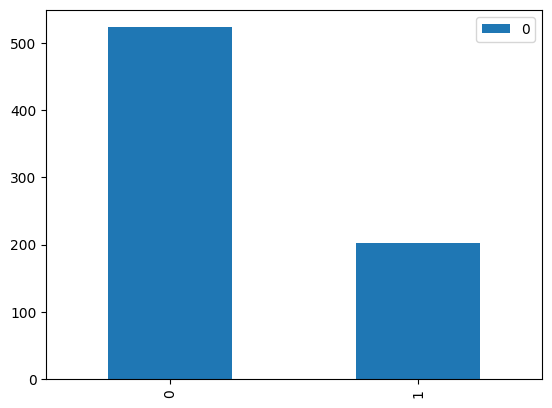

In [118]:
import numpy as np
from collections import Counter
state_counts = Counter(data[target])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar')

num=(df_state[0]/df_state[0].sum())**2

print("Population per class:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("Model Accuracy to Beat: {:0.2f}%".format(1.25*100*num.sum()))

Check Numerical and Categorical Columns  

In [92]:
# Identify categorical and numeric columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns
num_cols = data.select_dtypes(exclude=['object', 'category']).columns

print("Numeric columns:", num_cols.tolist())
print("Categorical columns:", cat_cols.tolist())

# --- Check for missing values ---
missing_info = data.isna().sum()  # count NaN per column
missing_info = missing_info[missing_info > 0]  # only show columns with NaN

if not missing_info.empty:
    print("\n🧩 Columns with missing values:")
    print(missing_info.sort_values(ascending=False))
else:
    print("\n✅ No missing values found in the dataset!")

# Fill all numeric columns with their mean
data[num_cols] = data[num_cols].apply(lambda x: x.fillna(x.mean()))

# (Optional) For categorical columns, you can fill NaN with a placeholder
data[cat_cols] = data[cat_cols].fillna("Unknown")

# Verify if any NaN remain
print("\nRemaining missing values after mean imputation:")
print(data.isna().sum()[data.isna().sum() > 0])



Numeric columns: ['Consistency_Qual', 'Style_Qual', 'Technical_Qual', 'Pace_Qual', 'PerformanceIndex_Qual', 'Round', 'year', 'QualifyingPosition', 'RaceFinishPosition', 'Laps', 'Corners', 'Circuit length (km)', 'Race distance (km)', 'Accident', 'Collision', 'Damage Related', 'Finish', 'Total_Entries', 'Finish_pct', 'Accident_pct', 'Collision_pct', 'Damage Related_pct', 'DNF_pct', 'Race_Complexity_Score', 'Safety_Index', 'mechanical_faults', 'avg_stops_per_car_race', 'avg_pitstop_ms']
Categorical columns: ['team', 'Direction']

🧩 Columns with missing values:
PerformanceIndex_Qual    2
Consistency_Qual         1
Style_Qual               1
dtype: int64

Remaining missing values after mean imputation:
Series([], dtype: int64)


One Hot Encoding

In [93]:
X = data.drop(columns=[target])
y = data[target]

# Separate categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Only build encoder if categorical columns exist
if len(cat_cols) > 0:
    ohe = OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=0.01,   # ~1% threshold for infrequent categories
        sparse_output=False,
        dtype=int              # ensures 0/1 not True/False
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ohe, cat_cols),
            ('num', 'passthrough', num_cols)
        ],
        remainder='drop'
    )

    # ⚠️ Use fit_transform only the first time
    X_encoded = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()
else:
    X_encoded = X.values
    feature_names = X.columns

data2 = pd.DataFrame(X_encoded, columns=feature_names)

# Attach target
data2 = pd.concat([data2, y.reset_index(drop=True)], axis=1)

print(data2.head())

   cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
0                     0.000                                   0.000   
1                     0.000                                   0.000   
2                     0.000                                   0.000   
3                     0.000                                   0.000   
4                     0.000                                   0.000   

   cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
0              1.000              0.000                       0.000   
1              1.000              0.000                       0.000   
2              0.000              1.000                       0.000   
3              0.000              1.000                       0.000   
4              0.000              0.000                       0.000   

   cat__team_McLaren Renault  cat__team_Mercedes  cat__team_Red Bull Racing  \
0                      0.000               0.000                   

# SPLIT TRAIN, VAIDATION, TEST

### SELECT TEST DATA

METHOD 1  
Last rows as test data. Best for Time Series

In [94]:
# # Separate features and target
# X = data2.drop(columns=[target])
# y = data2[target]
# num_latest_data = int(len(X)*0.05)
# # Final test: last 1000 rows (keep deterministic)
# X_test = X.tail(num_latest_data)
# y_test = y.tail(num_latest_data)

# # Remaining data
# X_train_val = X.iloc[:-num_latest_data]
# y_train_val = y.iloc[:-num_latest_data]

# print(f"Train and Val size: {len(X_train_val)} rows ({len(X_train_val)/len(X)*100:.1f}%)")
# print(f"Test size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")


METHOD 2  
General Method

In [95]:
# X = data2.drop(columns=[target])
# y = data2[target]

# # --- Step 1: Split into Train (70%) and Temp (30%) ---
# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X, y,
#     test_size=0.05,           # 30% for val+test
#     random_state=42,         # reproducibility
#     stratify=None            # set to y if classification
# )

# print(f"Train and Val size: {len(X_train_val)} rows ({len(X_train_val)/len(X)*100:.1f}%)")
# print(f"Test size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")

METHOD 3  
Future Predicting 2025 Data

In [96]:
print(data2.head())

   cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
0                     0.000                                   0.000   
1                     0.000                                   0.000   
2                     0.000                                   0.000   
3                     0.000                                   0.000   
4                     0.000                                   0.000   

   cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
0              1.000              0.000                       0.000   
1              1.000              0.000                       0.000   
2              0.000              1.000                       0.000   
3              0.000              1.000                       0.000   
4              0.000              0.000                       0.000   

   cat__team_McLaren Renault  cat__team_Mercedes  cat__team_Red Bull Racing  \
0                      0.000               0.000                   

In [97]:
# ✅ Split dataset by year
train_val_data = data2[data2["num__year"] < 2025].copy()    # all years before 2025
data_2025 = data2[data2["num__year"] == 2025].copy()        # only 2025 data

# --- Control what % of 2025 data to use for test ---
test_fraction = 0.99 # 👈 set this to the % (e.g., 0.3 = 30%, 0.5 = 50%)

data_2025_train, data_2025_test = train_test_split(
    data_2025,
    test_size=test_fraction,
    random_state=42,     # reproducibility
    shuffle=True         # shuffle so random subset of 2025 data
)

# Combine all training data (pre-2025 + part of 2025)
train_val_data = pd.concat([train_val_data, data_2025_train], ignore_index=True)
test_data = data_2025_test.copy()

# Define features and target
X_train_val = train_val_data.drop(columns=[target])
y_train_val = train_val_data[target]

X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# --- Display summary ---
print(f"Training + Validation size: {len(X_train_val)} rows ({len(X_train_val)/len(data2)*100:.1f}%)")
print(f"Test size ({test_fraction*100:.0f}% of 2025 data): {len(X_test)} rows ({len(X_test)/len(data2)*100:.1f}%)")


Training + Validation size: 601 rows (82.8%)
Test size (99% of 2025 data): 125 rows (17.2%)


In [98]:
print(X_test.head())

     cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
73                      0.000                                   0.000   
19                      0.000                                   0.000   
116                     0.000                                   0.000   
67                      0.000                                   0.000   
94                      0.000                                   0.000   

     cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
73               0.000              1.000                       0.000   
19               0.000              0.000                       0.000   
116              0.000              0.000                       0.000   
67               0.000              0.000                       0.000   
94               0.000              1.000                       0.000   

     cat__team_McLaren Renault  cat__team_Mercedes  cat__team_Red Bull Racing  \
73                       0.000           

### SELECT VALIDATION DATA

METHOD 1  
General method with Sklearn

In [99]:
X = X_train_val.copy()
y = y_train_val.copy()

# --- Step 1: Split into Train (70%) and Temp (30%) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.10,           # 30% for val+test
    random_state=42,         # reproducibility
    stratify=None            # set to y if classification
)

print(f"Train and Val size: {len(X_train)} rows ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_val)} rows ({len(X_val)/len(X)*100:.1f}%)")

Train and Val size: 540 rows (89.9%)
Test size: 61 rows (10.1%)


### DATA SCALING

In [100]:
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)   # fit on TRAIN only
# X_val_scaled   = scaler.transform(X_val)         # transform VAL with same scaler
# X_test_scaled  = scaler.transform(X_test)     

# ML MODELLING

Default Settings. Single Run. No Hyperparameter Tuning

In [102]:
# --- imports ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

# NEW: import an ordinal classifier
# !pip install mord --quiet
import mord as m  # Mord implements ordinal logistic regression (LogisticIT, OrdinalRidge, etc.)

# --- define models (pipelines where scaling helps) ---
pipe_lr  = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
pipe_svm = make_pipeline(MinMaxScaler(), SVC())
pipe_nb  = make_pipeline(MinMaxScaler(), GaussianNB())

DT  = DecisionTreeClassifier()
RF  = RandomForestClassifier()
GBM = GradientBoostingClassifier()
LGB = LGBMClassifier(verbose=-1)

# NEW: Ordinal Logistic Regression model (LogisticIT)
ORD = make_pipeline(MinMaxScaler(), m.LogisticIT())  # cumulative link model

# --- XGBoost requires encoded y ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
XGB = xgb.XGBClassifier(verbosity=0, eval_metric='mlogloss')

# --- fit on X_train/y_train ---
ORD.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_nb.fit(X_train, y_train)

DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
GBM.fit(X_train, y_train)
LGB.fit(X_train, y_train)
XGB.fit(X_train, y_train_enc)

# --- evaluate models ---
round_val = 5
cols = ['Machine Learning Classification Method', 'Train Accuracy', 'Validation Accuracy']
df_result = pd.DataFrame(columns=cols)

df_result.loc[0] = ['Ordinal Logistic Regression (mord)', round(ORD.score(X_train, y_train), round_val), round(ORD.score(X_val, y_val), round_val)]
df_result.loc[1] = ['Logistic Regression', round(pipe_lr.score(X_train, y_train), round_val), round(pipe_lr.score(X_val, y_val), round_val)]
df_result.loc[2] = ['kNN', round(pipe_knn.score(X_train, y_train), round_val), round(pipe_knn.score(X_val, y_val), round_val)]
# df_result.loc[3] = ['Decision Tree', round(DT.score(X_train, y_train), round_val), round(DT.score(X_val, y_val), round_val)]
df_result.loc[4] = ['Random Forest', round(RF.score(X_train, y_train), round_val), round(RF.score(X_val, y_val), round_val)]
df_result.loc[5] = ['Gradient Boosting', round(GBM.score(X_train, y_train), round_val), round(GBM.score(X_val, y_val), round_val)]
df_result.loc[6] = ['XGBoost', round(XGB.score(X_train, y_train_enc), round_val), round(XGB.score(X_val, y_val_enc), round_val)]
df_result.loc[7] = ['LightGBM', round(LGB.score(X_train, y_train), round_val), round(LGB.score(X_val, y_val), round_val)]
df_result.loc[8] = ['Support Vector Machine', round(pipe_svm.score(X_train, y_train), round_val), round(pipe_svm.score(X_val, y_val), round_val)]
# df_result.loc[9] = ['Naive Bayes', round(pipe_nb.score(X_train, y_train), round_val), round(pipe_nb.score(X_val, y_val), round_val)]

df_result = df_result.sort_values(by='Validation Accuracy', ascending=False)
df_result


,Machine Learning Classification Method,Train Accuracy,Validation Accuracy
4,Random Forest,1.000,0.869
0,Ordinal Logistic Regression (mord),0.843,0.836
1,Logistic Regression,0.841,0.836
5,Gradient Boosting,0.972,0.836
7,LightGBM,1.000,0.836
2,kNN,0.841,0.820
6,XGBoost,1.000,0.820
8,Support Vector Machine,0.846,0.820


ML Modelling: Single Run. Combining with Test Data

In [103]:
# table
cols = ['Machine Learning Classification Method','Train Accuracy','Validation Accuracy','Test Accuracy']
df_result2 = pd.DataFrame(columns=cols)
round_val = 8
df_result2.loc[0] = ['Logistic Regression', round(pipe_lr.score(X_train,y_train),round_val), round(pipe_lr.score(X_val,y_val),round_val), round(pipe_lr.score(X_test,y_test),round_val)]
df_result2.loc[1] = ['kNN', round(pipe_knn.score(X_train,y_train),round_val), round(pipe_knn.score(X_val,y_val),round_val), round(pipe_knn.score(X_test,y_test),round_val)]
# df_result2.loc[2] = ['Decision Tree', round(DT.score(X_train,y_train),round_val), round(DT.score(X_val,y_val),round_val), round(DT.score(X_test,y_test),round_val)]
df_result2.loc[3] = ['Random Forest', round(RF.score(X_train,y_train),round_val), round(RF.score(X_val,y_val),round_val), round(RF.score(X_test,y_test),round_val)]
df_result2.loc[4] = ['Gradient Boosting', round(GBM.score(X_train,y_train),round_val), round(GBM.score(X_val,y_val),round_val), round(GBM.score(X_test,y_test),round_val)]
df_result2.loc[5] = ['XGBoost', round(XGB.score(X_train,y_train_enc),round_val), round(XGB.score(X_val,y_val_enc),round_val), round(XGB.score(X_test,y_test_enc),round_val)]
df_result2.loc[6] = ['LightGBM', round(LGB.score(X_train,y_train),round_val), round(LGB.score(X_val,y_val),round_val), round(LGB.score(X_test,y_test),round_val)]
df_result2.loc[7] = ['Support Vector Machine', round(pipe_svm.score(X_train,y_train),round_val), round(pipe_svm.score(X_val,y_val),round_val), round(pipe_svm.score(X_test,y_test),round_val)]
# df_result2.loc[8] = ['Naive Bayes', round(pipe_nb.score(X_train,y_train),round_val), round(pipe_nb.score(X_val,y_val),round_val), round(pipe_nb.score(X_test,y_test),round_val)]

df_result2 = df_result2.sort_values(by='Validation Accuracy', ascending=False)
df_result2

,Machine Learning Classification Method,Train Accuracy,Validation Accuracy,Test Accuracy
3,Random Forest,1.000,0.869,0.848
0,Logistic Regression,0.841,0.836,0.744
4,Gradient Boosting,0.972,0.836,0.736
6,LightGBM,1.000,0.836,0.768
1,kNN,0.841,0.820,0.720
5,XGBoost,1.000,0.820,0.784
7,Support Vector Machine,0.846,0.820,0.680


# HYPERPARMETER TUNING: GRID SEARCH

ALL MODELS

In [123]:
# ============================================================
# 🏎️ Machine Learning Training Framework with Ordinal + Test Eval
# ============================================================

import time
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from skopt.callbacks import DeadlineStopper

# === Classifiers ===
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb
import mord as m
import ast

# ============================================================
# === Configuration ===
# ============================================================

# cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ============================================================
# === Helper functions ===
# ============================================================

def _final_estimator(est):
    """Return final estimator from pipeline or model."""
    return list(est.named_steps.values())[-1] if hasattr(est, "named_steps") else est

def _top_feature(estimator, X):
    """Return most important feature based on coefficients or importances."""
    est = _final_estimator(estimator)
    try:
        if hasattr(est, "feature_importances_"):
            idx = int(np.argmax(est.feature_importances_))
            return X.columns[idx]
        if hasattr(est, "coef_"):
            coef = np.asarray(est.coef_)
            if coef.ndim > 1:
                coef = np.mean(np.abs(coef), axis=0)
            idx = int(np.argmax(np.abs(coef)))
            return X.columns[idx]
    except Exception:
        pass
    return "NA"

# ============================================================
# === Core Training Function Template ===
# ============================================================

def _train_model(model_name, model, search_space, X, y, X_test, y_test):
    """Unified function for BayesSearchCV + test evaluation."""
    t0 = time.time()

    # Mord models skip BayesSearchCV since no params to tune
    if model_name == "Ordinal Logistic Regression (mord)":
        scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
        model.fit(X, y)
        test_score = model.score(X_test, y_test)
        return [
            model_name,
            scores.mean(),
            "{}",
            _top_feature(model, X),
            test_score,
            time.time() - t0,
        ]

    # Standard models with BayesSearchCV
    bayes = BayesSearchCV(model, search_space, n_iter=40, scoring="accuracy",
                          cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y)

    # Evaluate best model on test data
    best_model = bayes.best_estimator_
    test_score = best_model.score(X_test, y_test)

    return [
        model_name,
        bayes.best_score_,
        str(bayes.best_params_),
        _top_feature(best_model, X),
        test_score,
        time.time() - t0,
    ]

# ============================================================
# === Individual Model Functions ===
# ============================================================

def train_ordinal(X, y, X_test, y_test):
    model = make_pipeline(MinMaxScaler(), m.LogisticIT())
    return _train_model("Ordinal Logistic Regression (mord)", model, {}, X, y, X_test, y_test)

def train_logreg(X, y, X_test, y_test):
    pipe = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
    search = {
        "logisticregression__C": Real(1e-3, 1e3, prior="log-uniform"),
        "logisticregression__penalty": Categorical(["l2", "l1"]),
        "logisticregression__solver": Categorical(["liblinear", "saga"]),
    }
    return _train_model("Logistic Regression", pipe, search, X, y, X_test, y_test)

def train_knn(X, y, X_test, y_test):
    pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
    search = {
        "kneighborsclassifier__n_neighbors": Integer(1, 50),
        "kneighborsclassifier__weights": Categorical(["uniform", "distance"]),
        "kneighborsclassifier__p": Categorical([1, 2]),
    }
    return _train_model("kNN", pipe, search, X, y, X_test, y_test)

def train_dt(X, y, X_test, y_test):
    model = DecisionTreeClassifier(random_state=42)
    search = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical([None, "sqrt", "log2"]),
    }
    return _train_model("Decision Tree", model, search, X, y, X_test, y_test)

def train_rf(X, y, X_test, y_test):
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    search = {
        "n_estimators": Integer(80, 200),
        "max_depth": Integer(2, 20),
        "max_features": Categorical(["sqrt", "log2"]),
        "bootstrap": Categorical([True, False]),
        
    }
    return _train_model("Random Forest", model, search, X, y, X_test, y_test)

def train_gbm(X, y, X_test, y_test):
    model = GradientBoostingClassifier(random_state=42)
    search = {
        "n_estimators": Integer(80, 200),
        "learning_rate": Real(1e-2, 0.3, prior="log-uniform"),
        "max_depth": Integer(2, 6),
        "subsample": Real(0.5, 1.0),
    }
    return _train_model("Gradient Boosting", model, search, X, y, X_test, y_test)

def train_xgb(X, y, X_test, y_test):
    model = xgb.XGBClassifier(random_state=42, nthread=-1, tree_method="hist",
                              use_label_encoder=False, eval_metric="logloss")
    search = {
        "n_estimators": Integer(100, 1000),
        "learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
        "max_depth": Integer(2, 10),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0),
        "reg_lambda": Real(1e-3, 15.0, prior="log-uniform"),
        "reg_alpha": Real(1e-6, 1.0, prior="log-uniform"),
    }
    return _train_model("XGBoost", model, search, X, y, X_test, y_test)

def train_lgb(X, y, X_test, y_test):
    model = LGBMClassifier(random_state=42, n_jobs=-1)
    search = {
        "n_estimators": Integer(200, 1200),
        "learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
        "max_depth": Integer(-1, 50),
        "num_leaves": Integer(15, 255),
        "subsample": Real(0.5, 1.0),
    }
    return _train_model("LightGBM", model, search, X, y, X_test, y_test)

def train_svm(X, y, X_test, y_test):
    pipe = make_pipeline(MinMaxScaler(), SVC())
    search = {
        "svc__C": Real(1e-3, 1e3, prior="log-uniform"),
        "svc__kernel": Categorical(["linear", "rbf", "poly"]),
    }
    return _train_model("SVM", pipe, search, X, y, X_test, y_test)

def train_nb(X, y, X_test, y_test):
    model = GaussianNB()
    t0 = time.time()
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    model.fit(X, y)
    test_score = model.score(X_test, y_test)
    return [
        "Naive Bayes",
        scores.mean(),
        "{}",
        _top_feature(model, X),
        test_score,
        time.time() - t0,
    ]

In [105]:
# ==========================================
# Run Classification Models
# ==========================================
results = []

# Ordinal Logistic Regression
results.append(train_ordinal(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Ordinal Logistic Regression")

# Logistic Regression
results.append(train_logreg(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Logistic Regression")

# kNN
results.append(train_knn(X_train_val, y_train_val, X_test, y_test))
print("✅ done - kNN")

# # Decision Tree
# results.append(train_dt(X_train_val, y_train_val, X_test, y_test))
# print("✅ done - Decision Tree")


✅ done - Ordinal Logistic Regression
✅ done - Logistic Regression
✅ done - kNN


In [125]:

# Random Forest
results.append(train_rf(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Random Forest")


✅ done - Random Forest


In [107]:

# Gradient Boosting
results.append(train_gbm(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Gradient Boosting")

# XGBoost: encode y only for XGB
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_val_enc = le.fit_transform(y_train_val)
y_test_enc = le.transform(y_test)

results.append(train_xgb(X_train_val, y_train_val_enc, X_test, y_test_enc))
print("✅ done - XGBoost")


✅ done - Gradient Boosting
✅ done - XGBoost


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning:

[20:50:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




In [108]:

# LightGBM
results.append(train_lgb(X_train_val, y_train_val, X_test, y_test))
print("✅ done - LightGBM")

# Support Vector Machine
results.append(train_svm(X_train_val, y_train_val, X_test, y_test))
print("✅ done - SVM")

# Naive Bayes
# results.append(train_nb(X_train_val, y_train_val, X_test, y_test))
# print("✅ done - Naive Bayes")


✅ done - LightGBM
✅ done - SVM


In [127]:

# ==========================================
# Combine and Display Results
# ==========================================
df = pd.DataFrame(
    results,
    columns=['Model', 'CV Accuracy', 'Best Params', 'Top Feature', 'Test Accuracy', 'Runtime (s)']
)

# Sort by best CV Accuracy
df = df.sort_values('CV Accuracy', ascending=False).reset_index(drop=True)

print("\n=== Final Model Performance Summary ===")
display(df)



=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top Feature,Test Accuracy,Runtime (s)
0,Gradient Boosting,0.839,OrderedDict({'learning_rate': 0.02256750525295...,num__Pace_Qual,0.816,15.647
1,LightGBM,0.837,OrderedDict({'learning_rate': 0.00102092234948...,num__Pace_Qual,0.800,59.922
2,XGBoost,0.837,"OrderedDict({'colsample_bytree': 0.5, 'learnin...",num__Pace_Qual,0.800,21.594
3,Random Forest,0.832,"OrderedDict({'bootstrap': True, 'max_depth': 9...",num__Pace_Qual,0.816,22.789
4,Random Forest,0.832,"OrderedDict({'bootstrap': True, 'max_depth': 9...",num__Pace_Qual,0.816,23.180
5,Random Forest,0.832,"OrderedDict({'bootstrap': True, 'max_depth': 9...",num__Pace_Qual,0.816,15.251
6,Logistic Regression,0.824,OrderedDict({'logisticregression__C': 0.402231...,num__Pace_Qual,0.792,9.909
7,SVM,0.815,"OrderedDict({'svc__C': 0.28881766539144715, 's...",NA,0.776,10.592
8,Ordinal Logistic Regression (mord),0.802,{},num__Pace_Qual,0.744,0.289
9,kNN,0.772,OrderedDict({'kneighborsclassifier__n_neighbor...,NA,0.600,7.750


REFINED HYPERSPACE PARAMETER MODELLING: RANDOM FOREST

In [131]:
# ============================================================
# === Configuration ===
# ============================================================
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real, Integer, Categorical # Ensuring these are imported

pd.options.display.float_format = '{:.3f}'.format
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# === Start Random Forest Training
# ============================================================

print("🚀 Starting Random Forest training...")
t0 = time.time()

# Pipeline: Swapped GradientBoosting for RandomForest
pipe = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=42))

# Search Space: Adjusted for Random Forest specific params
# Note: 'learning_rate' is removed. 'max_features' is added.
search = {
    # Default is 100. We search a tighter range around it (50-200).
    "randomforestclassifier__n_estimators": Integer(50, 200),

    # Default is None (unlimited). 
    # We allow deeper trees (up to 50) to simulate the default behavior of growing fully.
    "randomforestclassifier__max_depth": Integer(10, 50),

    # Default is 2. We keep the range low (2-10) to avoid underfitting.
    "randomforestclassifier__min_samples_split": Integer(2, 10),

    # Default is 1. We keep this very low (1-4) to preserve the detailed trees of a standard RF.
    "randomforestclassifier__min_samples_leaf": Integer(1, 4),

    # Default is 'sqrt'. We remove 'None' (which uses all features) to stick to standard RF behavior.
    "randomforestclassifier__max_features": Categorical(['sqrt', 'log2']),
    
    # Default is True.
    "randomforestclassifier__bootstrap": Categorical([True, False])
}

# Run Bayesian Optimization
bayes = BayesSearchCV(
    pipe,
    search,
    n_iter=60,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# Fit the model
bayes.fit(X_train_val, y_train_val)
best_model = bayes.best_estimator_

# ============================================================
# === Predictions and Test Accuracy
# ============================================================

y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
runtime = round(time.time() - t0, 3)

# ============================================================
# === Extract Top 10 Features (Inline)
# ============================================================

est = list(best_model.named_steps.values())[-1] if hasattr(best_model, "named_steps") else best_model
top_features = "N/A"

try:
    if hasattr(est, "feature_importances_"):
        importances = np.asarray(est.feature_importances_)
        top_idx = np.argsort(importances)[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({importances[i]:.3f})" for i in top_idx])
    elif hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim > 1:
            coef = np.mean(np.abs(coef), axis=0)
        top_idx = np.argsort(np.abs(coef))[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({coef[i]:.3f})" for i in top_idx])
except Exception:
    top_features = "N/A"

# ============================================================
# === Build Summary DataFrame
# ============================================================

result = {
    "Model": "Random Forest",
    "CV Accuracy": round(bayes.best_score_, 3),
    "Best Params": bayes.best_params_,
    "Top 10 Features": top_features,
    "Test Accuracy": round(test_score, 3),
    "Runtime (s)": runtime,
}

df = pd.DataFrame([result])
print("\n=== Final Model Performance Summary ===")
display(df)

# ============================================================
# === Visualization of Search Space
# ============================================================

results_df = pd.DataFrame(bayes.cv_results_)
param_cols = [c for c in results_df.columns if c.startswith('param_')]
results_df = results_df.rename(columns={'mean_test_score': 'CV_Accuracy'})

# ============================================================
# === Show Predictions
# ============================================================

test_results = X_test.copy()
test_results["Actual"] = y_test
test_results["Predicted"] = y_pred

print("\n✅ Training complete!")
print(f"CV Accuracy: {result['CV Accuracy']}")
print(f"Test Accuracy: {result['Test Accuracy']}")
print(f"Runtime: {result['Runtime (s)']} seconds")
print(f"Top 10 Features:\n{result['Top 10 Features']}")

🚀 Starting Random Forest training...

=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top 10 Features,Test Accuracy,Runtime (s)
0,Random Forest,0.837,"{'randomforestclassifier__bootstrap': True, 'r...","num__Pace_Qual (0.250), num__QualifyingPositio...",0.848,47.658



✅ Training complete!
CV Accuracy: 0.837
Test Accuracy: 0.848
Runtime: 47.658 seconds
Top 10 Features:
num__Pace_Qual (0.250), num__QualifyingPosition (0.217), num__PerformanceIndex_Qual (0.048), num__Style_Qual (0.039), num__Technical_Qual (0.035), num__Consistency_Qual (0.035), num__avg_stops_per_car_race (0.033), cat__team_Red Bull Racing Honda RBPT (0.026), num__mechanical_faults (0.024), num__Round (0.022)


In [132]:
# ============================================================
# === Interactive Contour Plot: n_estimators vs max_depth (CV Accuracy)
# ============================================================

import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# Prepare data
contour_df = results_df.copy()
contour_df["n_estimators"] = contour_df["param_randomforestclassifier__n_estimators"].astype(float)
contour_df["max_depth"] = contour_df["param_randomforestclassifier__max_depth"].astype(float)
contour_df["CV_Accuracy"] = contour_df["CV_Accuracy"].astype(float)

# Extract data for interpolation
x = contour_df["max_depth"]
y = contour_df["n_estimators"]
z = contour_df["CV_Accuracy"]

# Create interpolation grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

# Create contour plot
fig = go.Figure(data=
    go.Contour(
        z=Zi,
        x=xi,  # max_depth
        y=yi,  # n_estimators
        colorscale='Viridis',
        ncontours=100,  # 
        contours=dict(showlabels=True, labelfont=dict(size=12, color='white')),
        colorbar=dict(title='CV Accuracy'),
    )
)

# Overlay actual sampled points
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=7,
        color=z,
        colorscale='Viridis',
        line=dict(width=0.7, color='white'),
        showscale=False
    ),
    text=[f"CV Accuracy: {val:.3f}" for val in z],
    hovertemplate="Learning Rate: %{x:.4f}<br>n_estimators: %{y}<br>CV Accuracy: %{text}<extra></extra>",
    name="Sampled Points"
))

# Annotate best point
best_idx = np.argmax(z)
fig.add_trace(go.Scatter(
    x=[x.iloc[best_idx]],
    y=[y.iloc[best_idx]],
    mode='markers+text',
    marker=dict(size=12, color='red', symbol='star'),
    text=["Best"],
    textposition="top center",
    name="Best Model"
))

# Layout
fig.update_layout(
    title="Gradient Boosting CV Accuracy Contour (Interactive)",
    xaxis_title="Max Depth",
    yaxis_title="Number of Estimators",
    template="plotly_white",
    width=900,
    height=600
)

fig.show()


REFINED HYPERSPACE PARAMETER MODELLING: XGBOOST
- Explore larger parameter space
- More refined tuning settings
- more predictors returned

In [119]:
# ============================================================
# === Imports
# ============================================================

import time
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from skopt import BayesSearchCV
from skopt.space import Integer, Real

import xgboost as xgb

import plotly.graph_objects as go
from scipy.interpolate import griddata

pd.options.display.float_format = '{:.3f}'.format

# Assumes you already have:
# X_train_val, X_test, y_train_val, y_test defined as usual

# ============================================================
# === Start XGBoost Model Training
# ============================================================

print("🚀 Starting XGBoost training...")
t0 = time.time()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe = make_pipeline(
    MinMaxScaler(),
    xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        # tree_method="gpu_hist",
        # device="cuda"
    )
)
search = {
    "xgbclassifier__n_estimators": Integer(300, 3000),
    "xgbclassifier__learning_rate": Real(1e-4, 0.05, prior="log-uniform"),
    "xgbclassifier__max_depth": Integer(2, 6),
    "xgbclassifier__colsample_bytree": Real(0.5, 1.0),
    "xgbclassifier__reg_lambda": Real(1e-3, 20.0, prior="log-uniform"),
    "xgbclassifier__reg_alpha": Real(1e-8, 1.0, prior="log-uniform"),
}
# # XGBoost search space
# search = {
#     "xgbclassifier__n_estimators": Integer(500, 1000),
#     "xgbclassifier__learning_rate": Real(0.0001, 0.1, prior="log-uniform"),
#     "xgbclassifier__max_depth": Integer(2, 12),
#     # "xgbclassifier__subsample": Real(0.5, 1.0, prior="uniform"),
#     # "xgbclassifier__colsample_bytree": Real(0.5, 1.0, prior="uniform"),
#     # "xgbclassifier__min_child_weight": Integer(1, 10),
#     # "xgbclassifier__gamma": Real(0, 5, prior="log-uniform"),
    
# }

# Run Bayesian Optimization
bayes = BayesSearchCV(
    estimator=pipe,
    search_spaces=search,
    n_iter=30,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
bayes.fit(X_train_val, y_train_val)

best_model = bayes.best_estimator_

# ============================================================
# === Predictions and Test Accuracy
# ============================================================

y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
runtime = round(time.time() - t0, 3)

# ============================================================
# === Extract Top 10 Features (Inline)
# ============================================================

# Get the XGBClassifier step explicitly
est = best_model.named_steps["xgbclassifier"]
top_features = "N/A"

try:
    if hasattr(est, "feature_importances_"):
        importances = np.asarray(est.feature_importances_)
        top_idx = np.argsort(importances)[::-1][:10]
        top_features = ", ".join(
            f"{X_train_val.columns[i]} ({importances[i]:.3f})"
            for i in top_idx
        )
    elif hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim > 1:
            coef = np.mean(np.abs(coef), axis=0)
        top_idx = np.argsort(np.abs(coef))[::-1][:10]
        top_features = ", ".join(
            f"{X_train_val.columns[i]} ({coef[i]:.3f})"
            for i in top_idx
        )
except Exception as e:
    print(f"[WARN] Could not compute top features: {e}")
    top_features = "N/A"

# ============================================================
# === Build Summary DataFrame
# ============================================================

result = {
    "Model": "XGBoost",
    "CV Accuracy": round(bayes.best_score_, 3),
    "Best Params": bayes.best_params_,
    "Top 10 Features": top_features,
    "Test Accuracy": round(test_score, 3),
    "Runtime (s)": runtime,
}

df = pd.DataFrame([result])
print("\n=== Final Model Performance Summary ===")
try:
    display(df)  # works in Jupyter
except NameError:
    print(df)

print("\n✅ Training complete!")
print(f"CV Accuracy: {result['CV Accuracy']}")
print(f"Test Accuracy: {result['Test Accuracy']}")
print(f"Runtime: {result['Runtime (s)']} seconds")
print(f"Top 10 Features:\n{result['Top 10 Features']}")

# Save full CV results
results_df = pd.DataFrame(bayes.cv_results_)

# ============================================================
# === Interactive Contour Plot: n_estimators vs learning_rate (CV Accuracy)
# ============================================================

contour_df = results_df.copy()

# IMPORTANT: in cv_results_ the param columns are prefixed with 'param_'
contour_df["n_estimators"] = contour_df["param_xgbclassifier__n_estimators"].astype(float)
contour_df["learning_rate"] = contour_df["param_xgbclassifier__learning_rate"].astype(float)

# For accuracy, BayesSearchCV stores CV mean score in 'mean_test_score'
contour_df["CV_Accuracy"] = contour_df["mean_test_score"].astype(float)

# Extract data for interpolation
x = contour_df["learning_rate"]
y = contour_df["n_estimators"]
z = contour_df["CV_Accuracy"]

# Create interpolation grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)

# Interpolation can fail for 'cubic' with few points, so we fall back if needed
try:
    Zi = griddata((x, y), z, (Xi, Yi), method="cubic")
except Exception:
    Zi = griddata((x, y), z, (Xi, Yi), method="linear")

# Create contour plot
fig = go.Figure(
    data=go.Contour(
        z=Zi,
        x=xi,  # learning_rate
        y=yi,  # n_estimators
        colorscale="Viridis",
        ncontours=50,
        contours=dict(showlabels=True, labelfont=dict(size=12, color="white")),
        colorbar=dict(title="CV Accuracy"),
    )
)

# Overlay actual sampled points
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode="markers",
        marker=dict(
            size=7,
            color=z,
            colorscale="Viridis",
            line=dict(width=0.7, color="white"),
            showscale=False,
        ),
        text=[f"{val:.3f}" for val in z],
        hovertemplate=(
            "Learning Rate: %{x:.4f}<br>"
            "n_estimators: %{y}<br>"
            "CV Accuracy: %{text}<extra></extra>"
        ),
        name="Sampled Points",
    )
)

# Annotate best point
best_idx = np.argmax(z.values)
fig.add_trace(
    go.Scatter(
        x=[x.iloc[best_idx]],
        y=[y.iloc[best_idx]],
        mode="markers+text",
        marker=dict(size=12, color="red", symbol="star"),
        text=["Best"],
        textposition="top center",
        name="Best Model",
    )
)

# Layout
fig.update_layout(
    title="XGBoost CV Accuracy Contour (n_estimators vs learning_rate)",
    xaxis_title="Learning Rate",
    yaxis_title="Number of Estimators",
    template="plotly_white",
    width=900,
    height=600,
)

fig.show()

test_results = X_test.copy()
test_results["Actual"] = y_test
test_results["Predicted"] = y_pred


🚀 Starting XGBoost training...

=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top 10 Features,Test Accuracy,Runtime (s)
0,XGBoost,0.839,{'xgbclassifier__colsample_bytree': 0.84718208...,"num__Pace_Qual (0.217), num__QualifyingPositio...",0.800,23.935



✅ Training complete!
CV Accuracy: 0.839
Test Accuracy: 0.8
Runtime: 23.935 seconds
Top 10 Features:
num__Pace_Qual (0.217), num__QualifyingPosition (0.209), cat__team_Williams Mercedes (0.127), num__avg_pitstop_ms (0.052), cat__team_Mercedes (0.037), num__mechanical_faults (0.034), num__avg_stops_per_car_race (0.032), num__year (0.024), num__PerformanceIndex_Qual (0.022), cat__team_Red Bull Racing Honda RBPT (0.021)


REFINED HYPERSPACE PARAMETER MODELLING: Gradient Boosting

In [126]:
# ============================================================
# === Configuration ===
# ============================================================

pd.options.display.float_format = '{:.3f}'.format
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# === Start Gradient Boosting Model Training
# ============================================================

print("🚀 Starting Gradient Boosting training...")
t0 = time.time()

# Pipeline and parameter space
pipe = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42))
search = {
    "gradientboostingclassifier__n_estimators": Integer(300, 800),
    "gradientboostingclassifier__learning_rate": Real(0.00001, 0.1, prior="log-uniform"),
    # "gradientboostingclassifier__max_depth": Integer(2, 10),
    # "gradientboostingclassifier__subsample": Real(0.5, 1.0, prior="uniform"),
    # "gradientboostingclassifier__min_samples_split": Integer(2, 20),
}

# Run Bayesian Optimization
bayes = BayesSearchCV(
    pipe,
    search,
    n_iter=60,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
bayes.fit(X_train_val, y_train_val)

best_model = bayes.best_estimator_

# ============================================================
# === Predictions and Test Accuracy
# ============================================================

y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
runtime = round(time.time() - t0, 3)

# ============================================================
# === Extract Top 10 Features (Inline)
# ============================================================

est = list(best_model.named_steps.values())[-1] if hasattr(best_model, "named_steps") else best_model
top_features = "N/A"

try:
    if hasattr(est, "feature_importances_"):
        importances = np.asarray(est.feature_importances_)
        top_idx = np.argsort(importances)[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({importances[i]:.3f})" for i in top_idx])
    elif hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim > 1:
            coef = np.mean(np.abs(coef), axis=0)
        top_idx = np.argsort(np.abs(coef))[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({coef[i]:.3f})" for i in top_idx])
except Exception:
    top_features = "N/A"

# ============================================================
# === Build Summary DataFrame
# ============================================================

result = {
    "Model": "Gradient Boosting",
    "CV Accuracy": round(bayes.best_score_, 3),
    "Best Params": bayes.best_params_,
    "Top 10 Features": top_features,
    "Test Accuracy": round(test_score, 3),
    "Runtime (s)": runtime,
}

df = pd.DataFrame([result])
print("\n=== Final Model Performance Summary ===")
display(df)

# ============================================================
# === Visualization of Search Space
# ============================================================

results_df = pd.DataFrame(bayes.cv_results_)
param_cols = [c for c in results_df.columns if c.startswith('param_')]
results_df = results_df.rename(columns={'mean_test_score': 'CV_Accuracy'})

# ============================================================
# === Show Predictions
# ============================================================


test_results = X_test.copy()
test_results["Actual"] = y_test
test_results["Predicted"] = y_pred

# if hasattr(best_model, "predict_proba"):
#     test_results["Predicted_Prob"] = np.max(best_model.predict_proba(X_test), axis=1)
print("\n✅ Training complete!")
print(f"CV Accuracy: {result['CV Accuracy']}")
print(f"Test Accuracy: {result['Test Accuracy']}")
print(f"Runtime: {result['Runtime (s)']} seconds")
print(f"Top 10 Features:\n{result['Top 10 Features']}")


🚀 Starting Gradient Boosting training...

=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top 10 Features,Test Accuracy,Runtime (s)
0,Gradient Boosting,0.832,{'gradientboostingclassifier__learning_rate': ...,"num__Pace_Qual (0.654), num__QualifyingPositio...",0.808,86.211



✅ Training complete!
CV Accuracy: 0.832
Test Accuracy: 0.808
Runtime: 86.211 seconds
Top 10 Features:
num__Pace_Qual (0.654), num__QualifyingPosition (0.090), num__mechanical_faults (0.063), num__avg_pitstop_ms (0.036), num__Consistency_Qual (0.019), num__Technical_Qual (0.015), num__Style_Qual (0.015), num__PerformanceIndex_Qual (0.014), num__Corners (0.012), num__Damage Related_pct (0.009)


In [ ]:
# ============================================================
# === Interactive Contour Plot: n_estimators vs learning_rate (CV Accuracy)
# ============================================================

import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# Prepare data
contour_df = results_df.copy()
contour_df["n_estimators"] = contour_df["param_gradientboostingclassifier__n_estimators"].astype(float)
contour_df["learning_rate"] = contour_df["param_gradientboostingclassifier__learning_rate"].astype(float)
contour_df["CV_Accuracy"] = contour_df["CV_Accuracy"].astype(float)

# Extract data for interpolation
x = contour_df["learning_rate"]
y = contour_df["n_estimators"]
z = contour_df["CV_Accuracy"]

# Create interpolation grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

# Create contour plot
fig = go.Figure(data=
    go.Contour(
        z=Zi,
        x=xi,  # learning_rate
        y=yi,  # n_estimators
        colorscale='Viridis',
        ncontours=100,  # 
        contours=dict(showlabels=True, labelfont=dict(size=12, color='white')),
        colorbar=dict(title='CV Accuracy'),
    )
)

# Overlay actual sampled points
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=7,
        color=z,
        colorscale='Viridis',
        line=dict(width=0.7, color='white'),
        showscale=False
    ),
    text=[f"CV Accuracy: {val:.3f}" for val in z],
    hovertemplate="Learning Rate: %{x:.4f}<br>n_estimators: %{y}<br>CV Accuracy: %{text}<extra></extra>",
    name="Sampled Points"
))

# Annotate best point
best_idx = np.argmax(z)
fig.add_trace(go.Scatter(
    x=[x.iloc[best_idx]],
    y=[y.iloc[best_idx]],
    mode='markers+text',
    marker=dict(size=12, color='red', symbol='star'),
    text=["Best"],
    textposition="top center",
    name="Best Model"
))

# Layout
fig.update_layout(
    title="Gradient Boosting CV Accuracy Contour (Interactive)",
    xaxis_title="Learning Rate",
    yaxis_title="Number of Estimators",
    template="plotly_white",
    width=900,
    height=600
)

fig.show()


## PLOTTING RESULTS  
Top Features

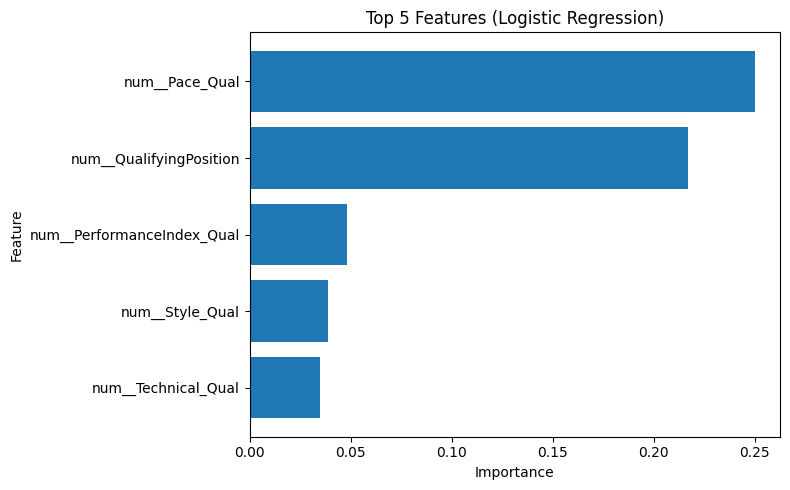

In [133]:

import matplotlib.pyplot as plt
import pandas as pd
import re

# Parse "feature (importance)" pairs from the result string
feature_str = result["Top 10 Features"]

if isinstance(feature_str, str) and feature_str != "N/A":
    # Use regex to extract (feature, importance)
    pattern = r"([\w\-]+)\s*\(([-+]?\d*\.\d+|\d+)\)"
    parsed = re.findall(pattern, feature_str)

    if parsed:
        top_features_df = pd.DataFrame(parsed, columns=["Feature", "Importance"])
        top_features_df["Importance"] = top_features_df["Importance"].astype(float)

        # Select top 5
        top5 = top_features_df.head(5)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.barh(top5["Feature"], top5["Importance"])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Top 5 Features (Logistic Regression)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Could not parse feature importance string.")
else:
    print("⚠️ No feature importance data available.")


MERGING DATA FOR PLOTTING

In [135]:
data_raw.head()

,Timestamp,driver_code,Consistency_Race,Style_Race,Technical_Race,Pace_Race,PerformanceIndex_Race,Consistency_Qual,Style_Qual,Technical_Qual,...,Finish_pct,Accident_pct,Collision_pct,Damage Related_pct,DNF_pct,Race_Complexity_Score,Safety_Index,mechanical_faults,avg_stops_per_car_race,avg_pitstop_ms
0,11/11/2025 20:10,HAM,0.487,0.870,0.308,0.885,0.637,0.254,0.203,0.403,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
1,11/11/2025 20:10,LEC,0.500,0.204,0.574,0.500,0.444,0.000,0.200,0.305,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
2,11/11/2025 20:10,NOR,0.664,0.549,0.326,1.000,0.635,0.169,0.500,0.417,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
3,11/11/2025 20:10,PIA,0.459,0.382,0.709,0.962,0.628,0.341,0.203,0.190,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
4,11/11/2025 20:10,RUS,0.480,0.532,0.403,0.654,0.517,0.464,0.792,0.232,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280


In [136]:
test_results.head()

,cat__team_Alpine Renault,cat__team_Aston Martin Aramco Mercedes,cat__team_Ferrari,cat__team_McLaren,cat__team_McLaren Mercedes,cat__team_McLaren Renault,cat__team_Mercedes,cat__team_Red Bull Racing,cat__team_Red Bull Racing Honda,cat__team_Red Bull Racing Honda RBPT,...,num__Collision_pct,num__Damage Related_pct,num__DNF_pct,num__Race_Complexity_Score,num__Safety_Index,num__mechanical_faults,num__avg_stops_per_car_race,num__avg_pitstop_ms,Actual,Predicted
73,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,10.784,0.000,13.725,0.415,0.448,0.000,1.892,160011.280,0,1
19,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.706,0.000,5.882,0.278,0.664,0.000,1.892,160011.280,0,0
116,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,8.000,0.000,14.400,0.478,0.378,0.000,1.892,160011.280,1,1
67,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,10.417,0.000,11.458,0.369,0.516,0.000,1.892,160011.280,0,0
94,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,8.738,0.000,12.621,0.392,0.481,0.000,1.892,160011.280,1,1


In [137]:
test_results = test_results.rename(columns={
    'num__PerformanceIndex_Qual': 'PerformanceIndex_Qual',
    # 'race_name': 'GrandPrix',
    # 'season': 'Year'
})

final_results = pd.merge(
    test_results,
    data_raw[['PerformanceIndex_Qual','driver_code', 'GrandPrix', 'year','team',"RaceFinishPosition"]],  # keep only relevant keys
    on=['PerformanceIndex_Qual'],
    how='left'   # keeps all rows from test_results
)


final_results.head()


,cat__team_Alpine Renault,cat__team_Aston Martin Aramco Mercedes,cat__team_Ferrari,cat__team_McLaren,cat__team_McLaren Mercedes,cat__team_McLaren Renault,cat__team_Mercedes,cat__team_Red Bull Racing,cat__team_Red Bull Racing Honda,cat__team_Red Bull Racing Honda RBPT,...,num__mechanical_faults,num__avg_stops_per_car_race,num__avg_pitstop_ms,Actual,Predicted,driver_code,GrandPrix,year,team,RaceFinishPosition
0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.892,160011.280,0,1,PIA,Canadian Grand Prix,2025,McLaren,4.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.892,160011.280,0,0,SAI,Chinese Grand Prix,2025,Williams,10.000
2,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,1.892,160011.280,1,1,RUS,Singapore Grand Prix,2025,Mercedes,1.000
3,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,1.892,160011.280,0,0,RUS,Spanish Grand Prix,2025,Mercedes,4.000
4,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.892,160011.280,1,1,PIA,Hungarian Grand Prix,2025,McLaren,2.000


PLOTTING Test Results

In [138]:
data_results=pd.read_csv(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1_Model_Results_v2.csv")
data_results=pd.read_csv(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1_Model_Results_v3.csv")
data_results=pd.read_csv(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1_Model_Results_v4.csv")

# data_results_v2 = final_results.copy()
data_results.columns

Index(['cat__team_Alpine Renault', 'cat__team_Aston Martin Aramco Mercedes',
       'cat__team_Ferrari', 'cat__team_McLaren', 'cat__team_McLaren Mercedes',
       'cat__team_McLaren Renault', 'cat__team_Mercedes',
       'cat__team_Red Bull Racing', 'cat__team_Red Bull Racing Honda',
       'cat__team_Red Bull Racing Honda RBPT',
       'cat__team_Red Bull Racing RBPT', 'cat__team_Renault',
       'cat__team_Williams', 'cat__team_Williams Mercedes',
       'cat__team_infrequent_sklearn', 'cat__Direction_Anti-clockwise',
       'cat__Direction_Clockwise', 'num__Consistency_Qual', 'num__Style_Qual',
       'num__Technical_Qual', 'num__Pace_Qual', 'PerformanceIndex_Qual',
       'num__Round', 'num__year', 'num__QualifyingPosition', 'num__Laps',
       'num__Corners', 'num__Circuit length (km)', 'num__Race distance (km)',
       'num__Accident', 'num__Collision', 'num__Damage Related', 'num__Finish',
       'num__Total_Entries', 'num__Finish_pct', 'num__Accident_pct',
       'num__Collisio

In [142]:
data_results_2 = data_results[[
    'PerformanceIndex_Qual',
    'num__Round',
    'num__year',
    'num__QualifyingPosition',
    # 'num__driver_points',
    # 'num__team_points',
    'num__Finish_pct',
    'num__Accident_pct',
    'num__Collision_pct',
    'num__Race_Complexity_Score',
    'num__Safety_Index',
    'Actual',
    'Predicted',
    # 'Predicted_Prob',
    'driver_code',
    'GrandPrix',
    'year',
    'team',
    'RaceFinishPosition'
]]

data_results_2.head()


,PerformanceIndex_Qual,num__Round,num__year,num__QualifyingPosition,num__Finish_pct,num__Accident_pct,num__Collision_pct,num__Race_Complexity_Score,num__Safety_Index,Actual,Predicted,driver_code,GrandPrix,year,team,RaceFinishPosition
0,0.541,10.000,2025.000,3.000,86.275,2.941,10.784,0.415,0.448,0,1,PIA,Canadian Grand Prix,2025,McLaren,4.000
1,0.525,2.000,2025.000,15.000,94.118,1.176,4.706,0.278,0.664,0,0,SAI,Chinese Grand Prix,2025,Williams,10.000
2,0.840,18.000,2025.000,1.000,85.600,6.400,8.000,0.478,0.378,1,1,RUS,Singapore Grand Prix,2025,Mercedes,1.000
3,0.579,9.000,2025.000,4.000,88.542,1.042,10.417,0.369,0.516,0,0,RUS,Spanish Grand Prix,2025,Mercedes,4.000
4,0.663,14.000,2025.000,2.000,87.379,3.883,8.738,0.392,0.481,1,1,PIA,Hungarian Grand Prix,2025,McLaren,2.000


In [144]:
import plotly.graph_objects as go
import numpy as np

# Sort data for chronological order
data_results_2 = data_results_2.sort_values(by='num__Round')

# Add a boolean column for correct predictions
data_results_2['Correct'] = np.where(
    data_results_2['Actual'] == data_results_2['Predicted'], 1, 0
)

# Map colors: green = correct, red = wrong
data_results_2['Color'] = np.where(
    data_results_2['Correct'] == 1, "#18e341", 'red'
)

# Get list of unique drivers
drivers = data_results_2['driver_code'].unique()

# Create figure
fig = go.Figure()

# Add one trace per driver
for driver in drivers:
    driver_data = data_results_2[data_results_2['driver_code'] == driver]
    fig.add_trace(go.Scatter(
        x=driver_data['GrandPrix'],
        y=driver_data['RaceFinishPosition'],
        mode='markers+lines',
        name=driver,
        text=driver_data['RaceFinishPosition'],
        textposition='top center',
        marker=dict(
            size=15,
            color=driver_data['Color'],      # red/green based on correctness
            line=dict(width=1, color='black')
        ),
        hovertemplate=(
            "<b>%{x}</b><br>"
            "Driver: <b>%{customdata[0]}</b><br>"
            "Team: %{customdata[1]}<br>"
            "Round: %{customdata[2]}<br>"
            "Finish: %{y}<br>"
            "Predicted: %{customdata[3]:.3f}<br>"
            "Actual: %{customdata[4]:.3f}<br>"
            "<b>Correct:</b> %{customdata[5]}<br>"
            "Prob: %{customdata[6]:.3f}<extra></extra>"
        ),
        customdata=np.stack([
            driver_data['driver_code'],
            driver_data['team'],
            driver_data['num__Round'],
            driver_data['Predicted'],
            driver_data['Actual'],
            np.where(driver_data['Correct'] == 1, '✅ Yes', '❌ No'),
            # driver_data['Predicted_Prob']
        ], axis=-1)
    ))

# Reverse Y-axis so P1 is on top
fig.update_yaxes(
    autorange='reversed',
    title_text='Race Finish Position'
)

# Set Grand Prix labels on X-axis
fig.update_xaxes(
    title_text='Grand Prix',
    tickangle=45,
    tickmode='array',
    tickvals=data_results_2['GrandPrix'].unique()
)

# Add Podium line (P3)
fig.add_shape(
    type='line',
    x0=-0.5,
    x1=len(data_results_2['GrandPrix'].unique()) - 0.5,
    y0=3,
    y1=3,
    line=dict(color='red', width=3, dash='dash'),
    xref='x',
    yref='y'
)

# Layout styling
fig.update_layout(
    title='🏁 Race Finish Position by Grand Prix (Colored by Prediction Accuracy)',
    template='plotly_white',
    hovermode='closest',
    legend_title_text='Driver',
    title_x=0.5,
    height=700,
)

fig.write_html("F1_Main_graph.html")
fig.show()



COMPARING with Naive Prediction
- Naive Prediction Simply uses Qualification Positions to predict the race winner

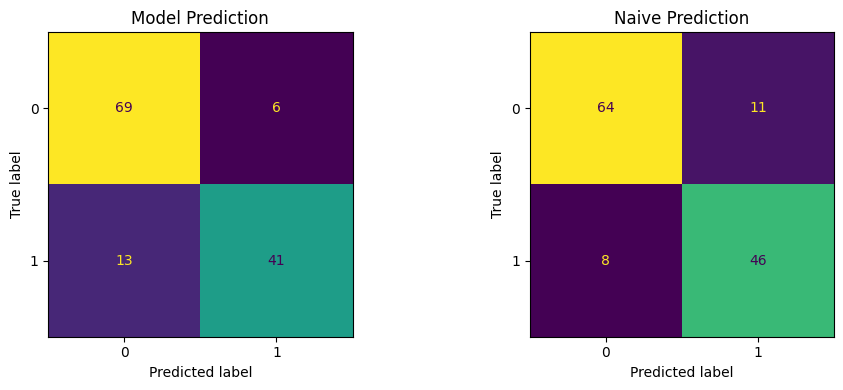

       accuracy  precision  recall    f1
Model     0.853      0.854   0.853 0.851
Rule      0.853      0.855   0.853 0.853


In [147]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

data_check = data_results_2

# PREDICTION USING QUALIFYING POSITION: 1st, 2nd, 3rd and No Podium ============================
qp = data_check["num__QualifyingPosition"]
# data_check["Qual_prediction"] = qp.where(qp <= 3, 0).astype(int)
data_check["Qual_prediction"] = (qp <= 3).astype(int)

# --- Set up y_true and predictions (multi-class) ---
y_true = pd.to_numeric(data_check["Actual"], errors="coerce").astype(int)

# Model prediction (if probs, convert to class; if already labels, just cast to int)
pred_raw = data_check["Predicted"]
y_model = (pd.to_numeric(pred_raw, errors="coerce").astype(int))

y_rule = pd.to_numeric(data_check["Qual_prediction"], errors="coerce").astype(int)

# Classes present in any of the series
labels = np.sort(np.unique(np.concatenate([y_true.values, y_model.values, y_rule.values])))

# Confusion matrices
cm_model = confusion_matrix(y_true, y_model, labels=labels)
cm_rule  = confusion_matrix(y_true, y_rule,  labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_model, display_labels=labels).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Model Prediction")
ConfusionMatrixDisplay(cm_rule, display_labels=labels).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Naive Prediction")
plt.tight_layout()
plt.show()

# Summary metrics (weighted for multi-class)
summary = pd.DataFrame({
    "accuracy":  [accuracy_score(y_true, y_model), accuracy_score(y_true, y_rule)],
    "precision": [precision_score(y_true, y_model, average="weighted", zero_division=0),
                  precision_score(y_true, y_rule,  average="weighted", zero_division=0)],
    "recall":    [recall_score(y_true, y_model, average="weighted", zero_division=0),
                  recall_score(y_true, y_rule,  average="weighted", zero_division=0)],
    "f1":        [f1_score(y_true, y_model, average="weighted", zero_division=0),
                  f1_score(y_true, y_rule,  average="weighted", zero_division=0)],
}, index=["Model", "Rule"])

print(summary)
